# 基于 LeNet5 的手写数字识别

## 实验介绍

LeNet5 + MNIST被誉为深度学习领域的“Hello world”。本实验主要介绍使用MindSpore在MNIST手写数字数据集上开发和训练一个LeNet5模型，并验证模型精度。

## 实验目的

- 了解如何使用MindSpore进行简单卷积神经网络的开发。
- 了解如何使用MindSpore进行简单图片分类任务的训练。
- 了解如何使用MindSpore进行简单图片分类任务的验证。

## 预备知识

- 熟练使用Python，了解Shell及Linux操作系统基本知识。
- 具备一定的深度学习理论知识，如卷积神经网络、损失函数、优化器，训练策略等。
- 了解并熟悉MindSpore AI计算框架，MindSpore官网：https://www.mindspore.cn
- 学习更多MindSpore实验案例，请前往：https://gitee.com/mindspore/course

## 实验环境

- MindSpore 深度学习框架

## 实验准备

### 数据集准备

MNIST是一个手写数字数据集，训练集包含60000张手写数字，测试集包含10000张手写数字，共10类。MNIST数据集的官网：[THE MNIST DATABASE](http://yann.lecun.com/exdb/mnist/)。

```
train-images-idx3-ubyte.gz:  training set images (9912422 bytes)
train-labels-idx1-ubyte.gz:  training set labels (28881 bytes)
t10k-images-idx3-ubyte.gz:   test set images (1648877 bytes)
t10k-labels-idx1-ubyte.gz:   test set labels (4542 bytes)
```

### 脚本准备

将脚本和数据集组织为如下形式：

```
lenet5
├── ./datasets/5fbdf571c06d3433df85ac65-momodel/MNIST
│   ├── test
│   │   ├── t10k-images-idx3-ubyte
│   │   └── t10k-labels-idx1-ubyte
│   └── train
│       ├── train-images-idx3-ubyte
│       └── train-labels-idx1-ubyte
└── lenet_mnist.ipynb # 或lenet_mnist.py
```

## 实验步骤

### 导入模块

导入MindSpore模块和辅助模块，设置MindSpore上下文，如执行模式、设备等。

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np

import mindspore as ms
import mindspore.context as context
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as CV

from mindspore import nn, Tensor
from mindspore.train import Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
from mindspore.train.serialization import load_checkpoint, load_param_into_net

has_gpu = (os.system('command -v nvidia-smi') == 0)
print('Excuting with', 'GPU' if has_gpu else 'CPU', '.')
context.set_context(mode=context.GRAPH_MODE, device_target='GPU' if has_gpu else 'CPU')

DATA_PATH = 'datasets/5fbdf571c06d3433df85ac65-momodel/MNIST/'
CKPT_DIR = 'results/ckpt_lenet'

Excuting with CPU .


### 数据处理

在使用数据集训练网络前，首先需要对数据进行预处理，如下：

In [3]:
def create_dataset(data_dir, training=True, batch_size=32, resize=(32, 32),
                   rescale=1/(255*0.3081), shift=-0.1307/0.3081, buffer_size=64):
    data_train = os.path.join(data_dir, 'train') # 训练集信息
    data_test = os.path.join(data_dir, 'test') # 测试集信息
    print(data_train)
    print(data_test)
    ds = ms.dataset.MnistDataset(data_train if training else data_test)

    ds = ds.map(input_columns=["image"], operations=[CV.Resize(resize), CV.Rescale(rescale, shift), CV.HWC2CHW()])
    ds = ds.map(input_columns=["label"], operations=C.TypeCast(ms.int32))
    # When `dataset_sink_mode=True` on Ascend, append `ds = ds.repeat(num_epochs) to the end
    ds = ds.shuffle(buffer_size=buffer_size).batch(batch_size, drop_remainder=True)

    return ds

对其中几张图片进行可视化，可以看到图片中的手写数字，图片的大小为32x32。

In [ ]:
import matplotlib.pyplot as plt
ds = create_dataset(DATA_PATH, training=False)
data = ds.create_dict_iterator().get_next()
images = data['image'].asnumpy()
labels = data['label'].asnumpy()

for i in range(1, 5):
    plt.subplot(2, 2, i)
    plt.imshow(images[i][0])
    plt.title('Number: %s' % labels[i])
    plt.xticks([])
plt.show()

### 定义模型

定义 LeNet5 模型，模型结构如下图所示：

<img src="https://imgbed.momodel.cn/lenet5.jpg"/>
<!-- ![](_images/lenet5.jpg) -->

[1] 图片来源于http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf

> **提示**: MindSpore model_zoo中提供了多种常见的模型，可以直接使用。

In [4]:
class LeNet5(nn.Cell):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, stride=1, pad_mode='valid')
        self.conv2 = nn.Conv2d(6, 16, 5, stride=1, pad_mode='valid')
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(400, 120)
        self.fc2 = nn.Dense(120, 84)
        self.fc3 = nn.Dense(84, 10)

    def construct(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

### 训练

使用MNIST数据集对上述定义的LeNet5模型进行训练。训练策略如下表所示，可以调整训练策略并查看训练效果，要求验证精度大于95%。

| batch size | number of epochs | learning rate | optimizer |
| -- | -- | -- | -- |
| 32 | 3 | 0.01 | Momentum 0.9 |

#### Callback

MindSpore提供了Callback功能，可用于训练/测试过程中执行特定的任务。常用的Callback如下：

- `ModelCheckpoint`：保存网络模型和参数，用于再训练或推理；
- `LossMonitor`：监控loss值，当loss值为Nan或Inf时停止训练；
- `SummaryStep`：把训练过程中的信息存储到文件中，用于后续查看或可视化展示。

`ModelCheckpoint`会生成模型（.meta）和Chekpoint（.ckpt）文件，如每个epoch结束时，都保存一次checkpoint。

#### 评估指标

MindSpore提供了多种Metric评估指标，如`accuracy`、`loss`、`precision`、`recall`、`F1`。定义一个metrics字典/元组，里面包含多种指标，传递给`Model`，然后调用`model.eval`接口来计算这些指标。`model.eval`会返回一个字典，包含各个指标及其对应的值。

In [7]:
# Please remove stale checkpoint folder `ckpt`
os.system(f'rm -rf {CKPT_DIR}')

def train(data_dir, lr=0.01, momentum=0.9, num_epochs=3, ckpt_name="lenet"):
    ds_train = create_dataset(data_dir)
    ds_eval = create_dataset(data_dir, training=False)
    steps_per_epoch = ds_train.get_dataset_size()
    print(steps_per_epoch)
    net = LeNet5()
    loss = nn.loss.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
    opt = nn.Momentum(net.trainable_params(), lr, momentum)

    ckpt_cfg = CheckpointConfig(save_checkpoint_steps=steps_per_epoch, keep_checkpoint_max=5)
    ckpt_cb = ModelCheckpoint(prefix=ckpt_name, directory=CKPT_DIR, config=ckpt_cfg)
    loss_cb = LossMonitor(steps_per_epoch)

    model = Model(net, loss, opt, metrics={'acc', 'loss'})
    model.train(num_epochs, ds_train, callbacks=[ckpt_cb, loss_cb], dataset_sink_mode=False)
    metrics = model.eval(ds_eval, dataset_sink_mode=False)
    print('Metrics:', metrics)

train(DATA_PATH)

datasets/5fbdf571c06d3433df85ac65-momodel/MNIST/train
datasets/5fbdf571c06d3433df85ac65-momodel/MNIST/test
datasets/5fbdf571c06d3433df85ac65-momodel/MNIST/train
datasets/5fbdf571c06d3433df85ac65-momodel/MNIST/test
1875
epoch: 1 step: 1875, loss is 2.30937
epoch: 2 step: 1875, loss is 0.03898326
epoch: 3 step: 1875, loss is 0.02329673


[WARNING] ME(66:139740716689216,MainProcess):2021-05-26-10:38:24.856.529 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


Metrics: {'loss': 0.07118182007868129, 'acc': 0.9780649038461539}


### 加载 Checkpoint 进行验证

mindspore提供了`load_checkpoint()`接口，可以将训练得到的checkpoint加载到新建的模型中，用于验证或推理。

In [5]:
CKPT = os.path.join(CKPT_DIR, 'lenet-3_1875.ckpt')

def eval(data_dir):
    ds_eval = create_dataset(data_dir, training=False)
    net = LeNet5()
    loss = nn.loss.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
    load_checkpoint(CKPT, net=net)
    model = Model(net, loss, metrics={'acc', 'loss'})
    metric = model.eval(ds_eval, dataset_sink_mode=False)
    print(metric)

eval(DATA_PATH)

[WARNING] ME(66:139740716689216,MainProcess):2021-05-26-10:36:39.844.213 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


datasets/5fbdf571c06d3433df85ac65-momodel/MNIST/train
datasets/5fbdf571c06d3433df85ac65-momodel/MNIST/test
{'loss': 0.0932431547374178, 'acc': 0.9715544871794872}


### 加载 Checkpoint 进行推理
  
使用训练后的LeNet5模型对手写数字进行识别，使用matplotlib将推理结果可视化，可以看到识别结果基本上是正确的。

datasets/5fbdf571c06d3433df85ac65-momodel/MNIST/train
datasets/5fbdf571c06d3433df85ac65-momodel/MNIST/test


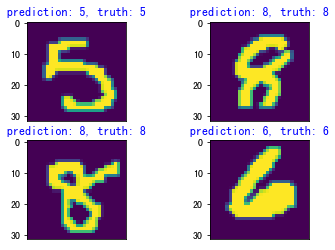

In [6]:
def infer(data_dir):
    ds = create_dataset(data_dir, training=False).create_dict_iterator(output_numpy=True)
    data = ds.get_next()
    images = data['image']
    labels = data['label']
    net = LeNet5()
    load_checkpoint(CKPT, net=net)
    model = Model(net)
    output = model.predict(Tensor(data['image']))
    preds = np.argmax(output.asnumpy(), axis=1)

    for i in range(1, 5):
        plt.subplot(2, 2, i)
        plt.imshow(np.squeeze(images[i]))
        color = 'blue' if preds[i] == labels[i] else 'red'
        plt.title("prediction: {}, truth: {}".format(preds[i], labels[i]), color=color)
        plt.xticks([])
    plt.show()

infer(DATA_PATH)

## 实验小结

本实验展示了如何使用MindSpore进行手写数字识别，以及开发和训练LeNet5模型。通过对LeNet5模型做几代的训练，然后使用训练后的LeNet5模型对手写数字进行识别，识别准确率大于95%。即LeNet5学习到了如何进行手写数字识别。